In [1]:
import os
os.environ['JULIA_PROJECT']="/home/jpd47/proj/HAL/Project.toml"

In [59]:

import ase
from ase import Atoms
from sklearn.linear_model import BayesianRidge, ARDRegression
#from ase.calculators.castep import Castep
from ase.io import read, write
#from ACEHAL.HAL import HAL
from pathlib import Path

# Get E0s and pick initial config

In [26]:
fname = "/data/jpd47/FeNiCr/Lakshmi_new/db10.xyz"
strucs = read(fname, index=":")
print(strucs[10].info.keys())

dict_keys(['config_type', 'config_name', 'energy', 'virial'])


In [27]:
atoms = [s for s in strucs if len(s) == 1]
for a in atoms:
    print(a.symbols, a.info["energy"])

Cr -5.4579557
Fe -3.09707575
Ni -0.52326479


In [28]:
configs = set([s.info["config_type"] for s in strucs])
bulk_md = [s for s in strucs if s.info["config_type"] == "bulk_md"]
bulk_md = sorted(bulk_md, key = lambda s: s.info["energy"])
Es = [s.info["energy"] for s in bulk_md]
print(Es[:10])
clean = bulk_md[0]
write("/home/jpd47/proj/HAL/initial/choice.xyz", [choice])

[-2056.90011549, -2056.45079759, -2055.90117573, -2055.66665719, -2055.63784995, -2055.48533593, -2055.30382152, -2055.16978469, -2055.12127745, -2055.09732296]


/home/jpd47/.local/lib/python3.10/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "magmoms" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


# Get calculator working

In [8]:
import quippy
from quippy.potential import Potential
from quippy.descriptors import Descriptor

In [39]:
calculator = Potential(param_filename="/home/jpd47/proj/HAL/gap_pot/n_max-8__l_max-4__radial_basis-EQUISPACED_GAUSS__n_sparse-1600.xml")

In [61]:
clean = ase.Atoms(choice.numbers, choice.positions, cell=choice.cell, pbc=True)
clean.set_calculator(calculator)
E = clean.get_potential_energy()
forces = clean.get_forces()
stress = clean.get_stress(voigt=False)
virial = clean.get_volume()*-1*stress
print(virial)
clean.info["virial"] = virial
clean.arrays["forces"] = clean._calc.results["forces"]
write("/home/jpd47/proj/HAL/0_conv.xyz", [clean])

[[106.00405799  -7.12294552  -5.23478852]
 [ -7.12294552  82.2448829   -6.2225932 ]
 [ -5.23478852  -6.2225932  103.02775234]]


/home/jpd47/.local/lib/python3.10/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


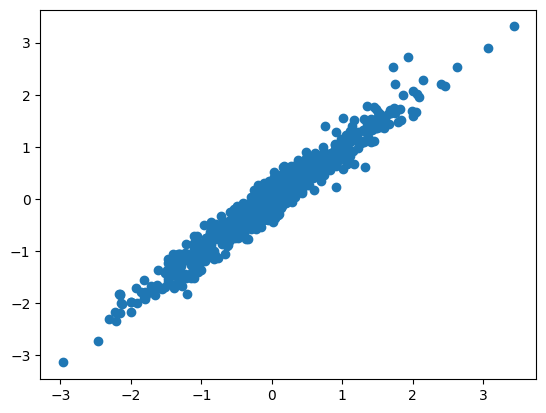

In [65]:
force = clean._calc.results["forces"].flatten()
choice = read("/home/jpd47/proj/HAL/initial/choice.xyz")
forces = choice.arrays["force"].flatten()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(forces, force)

# HAL

In [ ]:


fit_configs = read("../0_conv.xyz", ":")

# calculator = Castep()

# calculator._directory="./_CASTEP"
# calculator.param.cut_off_energy=500
# calculator.param.mixing_scheme='Pulay'
# calculator.param.write_checkpoint='none'
# calculator.param.finite_basis_corr='automatic'
# calculator.param.calculate_stress=True
# calculator.cell.kpoints_mp_spacing=0.04

E0s = { "Fe" : -3.09707575, "Ni" : -0.52326479, "Cr" : -5.4579557 }
data_keys = { "E" : "energy", "F" : "forces", "V" : "virial", "Fmax" : 20.0 }
weights = { "E" : 1.0, "F" : 1.0 ,"V": 1.0 }
#weights = { "E_per_atom": 1.0 / 0.001, "F": 1.0 / 0.1, "V_per_atom": 1.0 / 0.01 }

solver = ARDRegression(threshold_lambda=10000, fit_intercept=True, compute_score=True)
#solver = BayesianRidge(fit_intercept=True, compute_score=True)

fit_kwargs={"E0s": E0s, "data_keys": data_keys, "weights": weights}

fixed_basis_info = {"elements": list(E0s.keys()), "smoothness_prior" : ["algebraic", 2] }
optimize_params = {"cor_order": ("int", (2, 3)), "maxdeg": ("int", (3, 10)), "r_cut": ("float", (5.5, 8.0))}

HAL(fit_configs, fit_configs, None, solver,
            fit_kwargs={"E0s": E0s, "data_keys": data_keys, "weights": weights},
            n_iters=100, traj_len=2000, tol=0.2, tol_eps=0.2, tau_rel=0.2,
            ref_calc=calculator, dt=1.0, T_K=600, T_tau=100, P_GPa=1.0,
            basis_optim_kwargs={"n_trials": 20,
                                "timeout" : 10000,
                                "max_basis_len": 100000,
                                "fixed_basis_info": fixed_basis_info,
                                "optimize_params": optimize_params},
            basis_optim_interval=1, file_root="test_HAL",
            test_fraction=0.1)